In [97]:
import numpy as np
import os

import PIL.Image as Image
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sys

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   

The code will run on GPU.


<h2> Train a convolutional neural network that can classify single digits

<li>First training a CNN that can identify digits (if they are present).</li>
<li>We use CIFAR10 to train the network on non digit images.</li>
<li>The non digit class is represented by 10

In [94]:
batch_size = 64
size = 32

transformer_svhn = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize((.5,), (.5,))
])

transformer_cifar = transforms.Compose([
    transforms.RandomResizedCrop((size,size)),
    transforms.ToTensor(),
#     transforms.Normalize((.5,), (.5,))
])

# loading SVHN
svhn = datasets.SVHN('./data', download=True, transform=transformer_svhn)
svhn_loader = DataLoader(svhn, batch_size=batch_size, shuffle=True, num_workers=3)

# loading CIFAR10
cifar = datasets.CIFAR10("./data", download=True, transform=transformer_cifar)
cifar.targets = [10] * len(cifar.targets) #switching all label to 10, meaning "no digit"
cifar_loader = DataLoader(cifar, batch_size=batch_size, shuffle=True, num_workers=3)

Using downloaded and verified file: ./data/train_32x32.mat
Files already downloaded and verified


In [80]:
print("Length CIFAR10: {}".format(len(cifar_loader.dataset)))
print("Length SVHN: {}".format(len(svhn_loader.dataset)))

Length CIFAR10: 50000
Length SVHN: 73257


In [81]:
# concatenating both dataset in order to create the training set
train_set = cifar + svhn
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,num_workers=1)

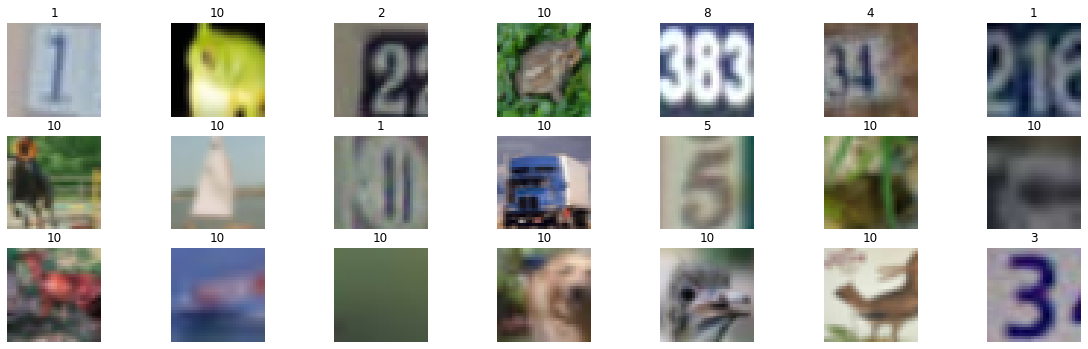

In [82]:
# ploting images of the dataset
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(range(11)[labels[i].item()])
    plt.axis('off')

In [86]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
                nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU())

        self.fully_connected = nn.Sequential(
                nn.Linear(32 * 16 * 16, 500),
                nn.ReLU(),
                nn.Linear(500, 11),
                nn.Softmax(dim=1))
    
    def forward(self, x):
        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x

In [90]:
def train_digit_classifier(model, optimizer, loss_function, num_epochs=5):
    train_acc_all = []
    
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        train_correct = 0
        
        model.train()
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data = data.to(device)
            target = target.to(device)
            
            # set the parameter gradients to zero
            optimizer.zero_grad()
            
            output = model(data)
            loss_size = loss_function(output, target)
            loss_size.backward()
            optimizer.step()
            
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().item()
        
        train_acc = train_correct / len(train_set)
        train_acc_all.append(train_acc)
        print("Training accuracy: {}%".format(100*train_acc))
    
    return train_acc_all

In [91]:
model = Network()
model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.0001)

train_acc = train_digit_classifier(model, optimizer, loss_function, num_epochs=10)

torch.save(model.state_dict(), "digit_classifier.pth")

Training accuracy: 40.54130799873435%


Training accuracy: 40.565647387166656%


Training accuracy: 42.41625222096919%


Training accuracy: 47.715748395628644%


Training accuracy: 51.40559968196532%


Training accuracy: 54.35228830816911%


Training accuracy: 58.04213959450579%


Training accuracy: 60.4257770349757%


Training accuracy: 61.446408723236814%


Training accuracy: 62.10844008859537%


<h2> Implementation of digit detection

In [98]:
class SVHN_(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/scratch/SVHN'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        list_files = os.listdir(data_path)
        self.image_paths = [os.path.join(data_path, file) for file in list_files]
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        X = self.transform(image)
        return X

In [103]:
# loading SVHN

transformer_svhn_train = transforms.Compose([
    transforms.ToTensor()
])

transformer_svhn_test = transforms.Compose([
    transforms.ToTensor()
])

SVHN_train = SVHN_(train=True, transform=transformer_svhn_train)
SVHN_train_loader = DataLoader(SVHN_train, batch_size=batch_size, shuffle=True, num_workers=3)
SVHN_test = SVHN_(train=False, transform=transformer_svhn_test)
SVHN_test_loader = DataLoader(SVHN_test, batch_size=batch_size, shuffle=True, num_workers=3)